# Adding channels to the data
We are adding encoded channels to our (time, latitude, longitude, channels) input. The encoded latitude and longitude channels are in the range of [-1 , 1].

In [2]:
import xarray as xr
from lossycomp.encodings import *
from lossycomp.constants import data_path
import numpy as np
test = xr.open_mfdataset(data_path + '/data/ECMWF/1980/*/temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1980-01-14T16:00:00','1980-01-15T07:00:00'),level = slice(978,1000), longitude=slice(6,20.75), latitude=slice(55.5,43.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data

<xarray.Dataset>
Dimensions:    (latitude: 48, level: 1, longitude: 60, time: 16)
Coordinates:
  * longitude  (longitude) float32 6.0 6.25 6.5 6.75 ... 20.0 20.25 20.5 20.75
  * latitude   (latitude) float32 55.5 55.25 55.0 54.75 ... 44.25 44.0 43.75
  * level      (level) int32 1000
  * time       (time) datetime64[ns] 1980-01-14T16:00:00 ... 1980-01-15T07:00:00
Data variables:
    t          (time, latitude, longitude, level) float32 dask.array<chunksize=(16, 48, 60, 1), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-07-08 13:03:33 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [3]:
#Getting latitude and longitude values

lat = test_data['t'].coords['latitude'].values
lon = test_data['t'].coords['longitude'].values

In [4]:
# Encoding the latitude and longitude values, comment them out if you dont want to encode

lat_st = np.stack([encode_lat(x) for x in lat])
lon_st = np.stack([encode_lon(x) for x in lon])

In [5]:
#Splitting the 2 attributes in order to build our grid of values

lat1, lat2 = np.hsplit(lat_st, 2)
lon1, lon2 = np.hsplit(lon_st, 2)

In [6]:
# Building 2 meshgrids with the 4 attributes

xx, yy = np.meshgrid(lon1, lat1)
xx2, yy2 = np.meshgrid(lon2, lat2)

#xx, yy = np.meshgrid(lon, lat) # Without encoding

In [7]:
# Concatenate the values to generate our 4 grids with the values. We multiply it by time so we get (time, lat, lon) grids.

coords_lon = np.concatenate([[xx]] * len(test_data.time), axis=0)
coords_lat = np.concatenate([[yy]] * len(test_data.time), axis=0)
coords_lon1 = np.concatenate([[xx2]] * len(test_data.time), axis=0)
coords_lat1 = np.concatenate([[yy2]] * len(test_data.time), axis=0)

#coords_lat = np.concatenate([[xx]] * len(test_data.time), axis=0) #Without encoding
#coords_lon = np.concatenate([[yy]] * len(test_data.time), axis=0) #Without encoding

In [8]:
# We expand one dimension since the we the input to the model requires the values as (time, lat, lon, value).

coords_lat = np.expand_dims(coords_lat, axis=3)
coords_lon = np.expand_dims(coords_lon, axis=3)

coords_lat1 = np.expand_dims(coords_lat1, axis=3)
coords_lon1 = np.expand_dims(coords_lon1, axis=3)

#coords_lat = np.expand_dims(coords_lat, axis=3) #Without encoding
#coords_lon = np.expand_dims(coords_lon, axis=3) #Without encoding

In [9]:
# We get the attribute values in order to concatenate it with the other information/channels.
temp = test_data['t'].values

In [10]:
# We concatenate them at the channel dimension.

all_val =  np.concatenate((temp, coords_lat, coords_lat1, coords_lon, coords_lon1),axis = 3)
#all_val =  np.concatenate((temp, coords_lon, coords_lat),axis = 3) #Without encoding

In [11]:
all_val.shape  #Check the number of channels

(16, 48, 60, 5)

In [12]:
test_data.isel(latitude = 3, longitude = 1).t.values  #Check the attribute values

array([[276.54477],
       [276.76416],
       [276.74606],
       [276.70084],
       [276.7958 ],
       [276.89758],
       [276.70987],
       [276.88855],
       [276.979  ],
       [276.98807],
       [276.979  ],
       [276.94736],
       [276.9383 ],
       [276.94736],
       [277.01068],
       [277.11926]], dtype=float32)

In [13]:
input_data = np.expand_dims(all_val[:,3,1,0], axis=1)
assert np.all(test_data.isel(latitude = 3, longitude = 1).t.values == input_data), "Data is not the same." #Check if they are the same values as the input.

## Coded latitude and longitude

In [14]:
import matplotlib.pyplot as plt
import math
import numpy as np
latitude = np.arange(0,181) /180
longitude = np.arange(0,361) /360

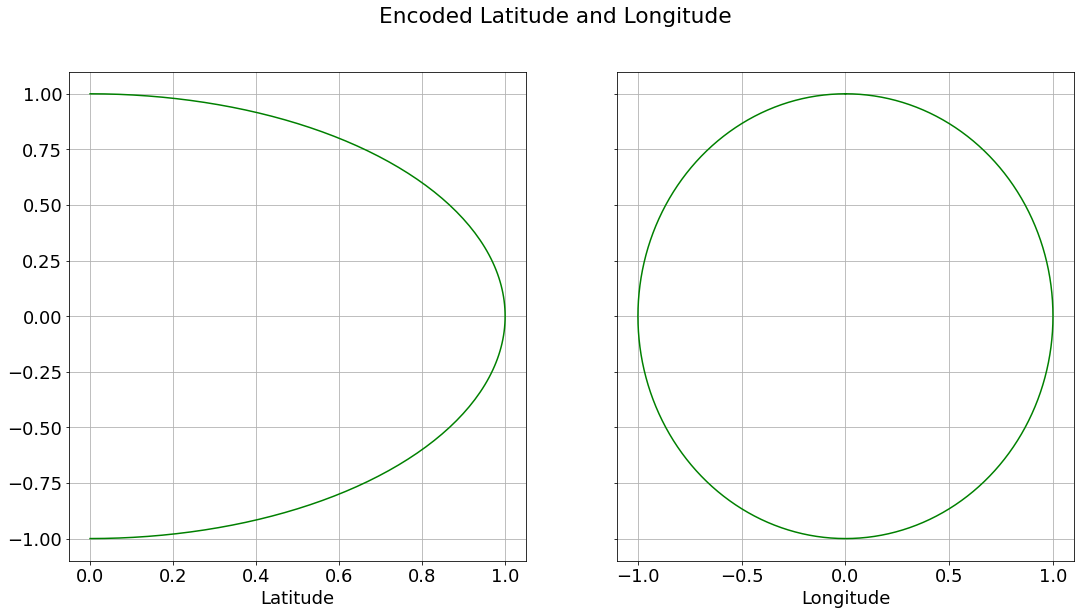

In [17]:
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize=(18,9))
fig.suptitle('Encoded Latitude and Longitude')
axs[0].plot( np.sin(math.pi*(latitude)) , np.cos(math.pi*(latitude)), 'g')
axs[1].plot( np.sin(2*math.pi*(longitude)) , np.cos(2*math.pi*(longitude)), 'g')

axs[0].set(xlabel='Latitude')
axs[1].set(xlabel='Longitude')
axs[0].grid()
axs[1].grid()

for ax in axs.flat:
    ax.label_outer()
plt.savefig('latitude_longitude.png' ,dpi=300,bbox_inches='tight')